## Import libraries

In [44]:
# standard libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 30) 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import math
# plt.figure(figsize=(16,6))  # set the plot size
# plt.ylim(-0.01, 0.04)  # set the axis zoom range
# plt.xlim(-0.01, 0.04)

import warnings
warnings.filterwarnings('ignore')

In [45]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

In [47]:
%%time
# import daily gmv, spend, cm for each leaf category from 2021
ts = pd.read_sql("""
                select dt, ramp, l1, l2, l3, l4, a.leaf_category, 
                            sum(gmv_w_cancel_est) gmv_w_cancel_est,
                            sum(spend) spend,
                            sum(cm) cm
                from mp.order_item_cm_metrics a
                left join wandajuan.llcm_leaf_split b 
                on a.leaf_category = b.leaf_category 
                where dt >= '2021-01-01'
                group by 1, 2, 3, 4, 5, 6, 7
                """, conn)
ts.head()

CPU times: user 2.12 s, sys: 214 ms, total: 2.33 s
Wall time: 1min 20s


,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm
0,2021-05-16,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,1676.66,-549.366267,44.964637
1,2021-05-18,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,2403.95,-434.553416,10.595741
2,2021-05-19,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,2557.55,-407.640265,98.330883
3,2021-05-22,C2,storage and organization,coatracks and umbrella stands,Unmapped,Unmapped,coatracks and umbrella stands,47.99,-49.112736,-39.057042
4,2021-05-24,C1,furniture,living room furniture,living room chairs,armchairs and accent chairs,armchairs and accent chairs,22933.18,-1469.897472,3545.978582


In [48]:
ts['dt'] = pd.to_datetime(ts['dt'])
ts['year'] = ts['dt'].dt.year
ts['month'] = ts['dt'].dt.to_period('M')
ts['week'] = ts['dt'].dt.to_period('W')
ts.head()

,dt,ramp,l1,l2,l3,l4,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week
0,2021-05-16,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,1676.66,-549.366267,44.964637,2021,2021-05,2021-05-10/2021-05-16
1,2021-05-18,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,2403.95,-434.553416,10.595741,2021,2021-05,2021-05-17/2021-05-23
2,2021-05-19,None,outdoor products,outdoor decor,garden statues and yard art,Unmapped,garden statues and yard art,2557.55,-407.640265,98.330883,2021,2021-05,2021-05-17/2021-05-23
3,2021-05-22,C2,storage and organization,coatracks and umbrella stands,Unmapped,Unmapped,coatracks and umbrella stands,47.99,-49.112736,-39.057042,2021,2021-05,2021-05-17/2021-05-23
4,2021-05-24,C1,furniture,living room furniture,living room chairs,armchairs and accent chairs,armchairs and accent chairs,22933.18,-1469.897472,3545.978582,2021,2021-05,2021-05-24/2021-05-30


## Bath vanities vs other bath product in control 

In [49]:
# make sure bathroom vanities and sink consoles is included here
ts_bath = ts.query('l1=="bath products" and ramp != "T1"')
ts_bath = ts_bath.assign(bathroom_vanities = np.where(ts_bath['leaf_category']=='bathroom vanities and sink consoles', 'vanities', 'other bath') ) 

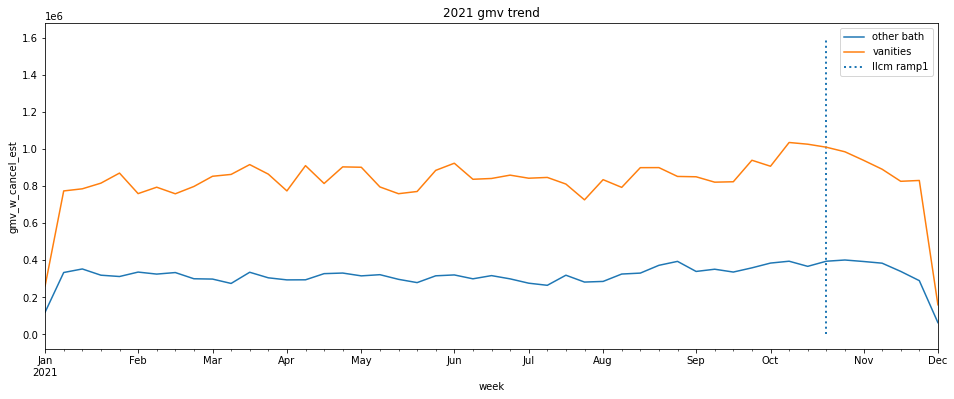

In [50]:
ts_bath.groupby(['week', 'bathroom_vanities'])['gmv_w_cancel_est'].sum().reset_index().\
        pivot('week', 'bathroom_vanities', 'gmv_w_cancel_est').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=500, ymax=1600000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv_w_cancel_est')
plt.title('2021 gmv trend')
plt.legend()

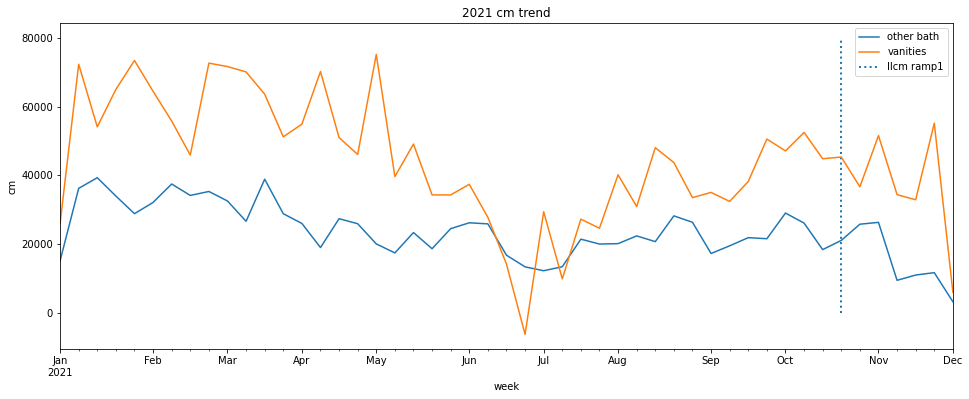

In [51]:
ts_bath.groupby(['week', 'bathroom_vanities'])['cm'].sum().reset_index().\
        pivot('week', 'bathroom_vanities', 'cm').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=80000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

## Bath treatment vs Bath control

In [30]:
# make sure bathroom vanities and sink consoles is included here
ts_bath_t = ts.query('l1=="bath products"')
ts_bath_t = ts_bath_t.assign(group = np.where((ts_bath_t['leaf_category']=='bathroom vanities and sink consoles') \
                                              |(ts_bath_t['ramp']=='T1'), 'treatment', 'control') ) 

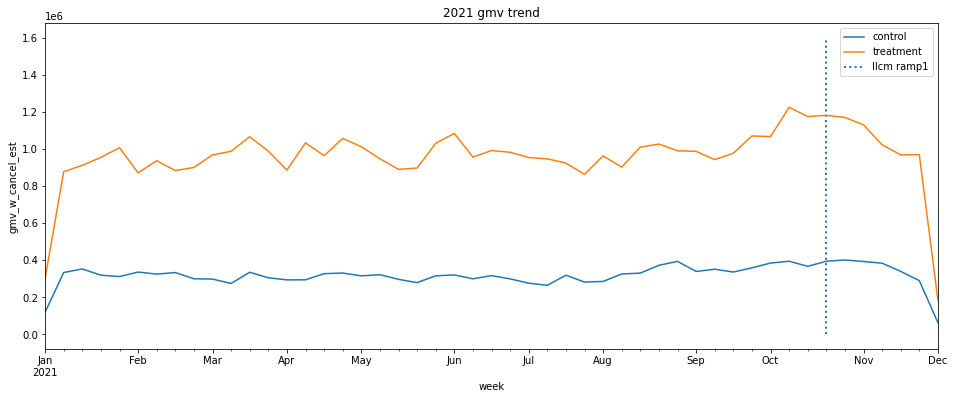

In [31]:
ts_bath_t.groupby(['week', 'group'])['gmv_w_cancel_est'].sum().reset_index().\
        pivot('week', 'group', 'gmv_w_cancel_est').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=500, ymax=1600000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv_w_cancel_est')
plt.title('2021 gmv trend')
plt.legend()

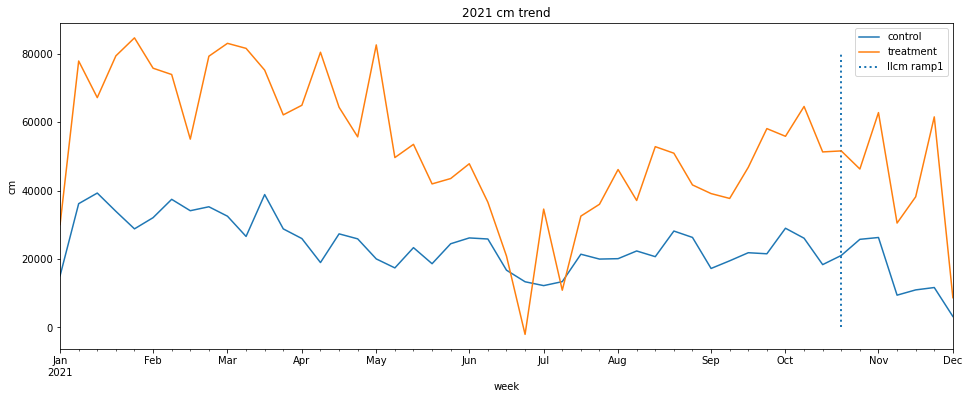

In [32]:
ts_bath_t.groupby(['week', 'group'])['cm'].sum().reset_index().\
        pivot('week', 'group', 'cm').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=80000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

### Preperiod 

<AxesSubplot:xlabel='week'>

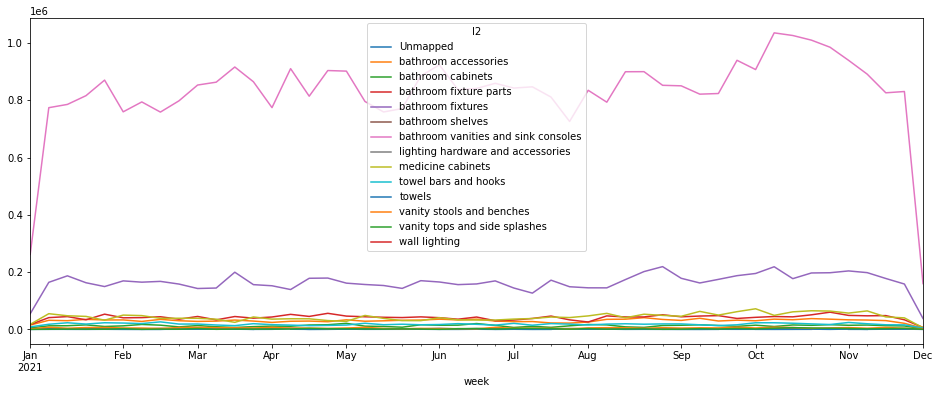

In [64]:
subgroup = 'l2'
metric = 'gmv_w_cancel_est'
ts_bath.groupby(['week', subgroup])[metric].sum().reset_index()\
    .pivot(index='week', columns=subgroup, values=metric).plot(figsize=(16, 6))

In [66]:
subgroup = 'l2'
metrics = ['gmv_w_cancel_est', 'cm']
# metrics = ['gmv_w_cancel_est']

preperiod = ts_bath.query('dt < "2021-10-22"')\
        .groupby(['week', subgroup])[metrics].sum().reset_index()\
        .pivot(index=subgroup, columns='week').T

preperiod

l2                                        Unmapped  bathroom accessories  \
                 week                                                      
gmv_w_cancel_est 2020-12-28/2021-01-03  139.000000          14997.250000   
                 2021-01-04/2021-01-10  125.000000          31692.540000   
                 2021-01-11/2021-01-17  220.330000          30329.326667   
                 2021-01-18/2021-01-24   50.000000          34939.301667   
                 2021-01-25/2021-01-31  352.500000          32842.400000   
...                                            ...                   ...   
cm               2021-09-20/2021-09-26         NaN           2745.449925   
                 2021-09-27/2021-10-03   39.353972           2831.403427   
                 2021-10-04/2021-10-10   21.527913           3538.672140   
                 2021-10-11/2021-10-17   12.280160           2507.694549   
                 2021-10-18/2021-10-24    4.748772           2108.284590   

l2                                      bathroom cabinets  \
                 week                                       
gmv_w_cancel_est 2020-12-28/2021-01-03        4964.360000   
                 2021-01-04/2021-01-10       12380.560000   
                 2021-01-11/2021-01-17       12740.200000   
                 2021-01-18/2021-01-24       15681.010000   
                 2021-01-25/2021-01-31       10114.590000   
...                                                   ...   
cm               2021-09-20/2021-09-26         926.865733   
                 2021-09-27/2021-10-03        1230.631744   
                 2021-10-04/2021-10-10           7.727679   
                 2021-10-11/2021-10-17         145.122726   
                 2021-10-18/2021-10-24         467.069811   

l2                                      bathroom fixture parts  \
                 week                                            
gmv_w_cancel_est 2020-12-28/2021-01-03            16528.270000   
                 2021-01-04/2021-01-10            41041.960000   
                 2021-01-11/2021-01-17            44589.130000   
                 2021-01-18/2021-01-24            33467.560000   
                 2021-01-25/2021-01-31            53116.722985   
...                                                        ...   
cm               2021-09-20/2021-09-26             -113.704306   
                 2021-09-27/2021-10-03              482.125827   
                 2021-10-04/2021-10-10              440.531895   
                 2021-10-11/2021-10-17             1510.608845   
                 2021-10-18/2021-10-24             1022.123115   

l2                                      bathroom fixtures  bathroom shelves  \
                 week                                                         
gmv_w_cancel_est 2020-12-28/2021-01-03       54442.600000       1414.730000   
                 2021-01-04/2021-01-10      164329.950000       3238.990000   
                 2021-01-11/2021-01-17      187013.170000       2431.180000   
                 2021-01-18/2021-01-24      162874.520000       1351.840000   
                 2021-01-25/2021-01-31      149563.677015       3867.810000   
...                                                   ...               ...   
cm               2021-09-20/2021-09-26       13874.641135        288.207472   
                 2021-09-27/2021-10-03       13489.741269        199.274857   
                 2021-10-04/2021-10-10       17009.832868        232.086155   
                 2021-10-11/2021-10-17        7113.721197        292.757283   
                 2021-10-18/2021-10-24        7759.927518         75.610072   

l2                                      bathroom vanities and sink consoles  \
                 week                                                         
gmv_w_cancel_est 2020-12-28/2021-01-03                        262029.530000   
                 2021-01-04/2021-01-10                        774312.660000   
              

In [74]:
preperiod.xs('gmv_w_cancel_est')['bathroom vanities and sink consoles']

week
2020-12-28/2021-01-03     262029.53
2021-01-04/2021-01-10     774312.66
2021-01-11/2021-01-17     785713.97
2021-01-18/2021-01-24     816271.77
2021-01-25/2021-01-31     870608.11
                            ...    
2021-09-20/2021-09-26     939819.63
2021-09-27/2021-10-03     907458.58
2021-10-04/2021-10-10    1035620.00
2021-10-11/2021-10-17    1026396.23
2021-10-18/2021-10-24     631829.70
Freq: W-SUN, Name: bathroom vanities and sink consoles, Length: 43, dtype: float64

In [83]:
y_train = {}
X_train = {}

metrics = ['gmv_w_cancel_est', 'cm']

for metric in metrics:
    y_train[metric] = preperiod.xs(metric)['bathroom vanities and sink consoles'].fillna(0).values
    X_train[metric] = preperiod.xs(metric).drop(columns = 'bathroom vanities and sink consoles').fillna(0).values
    print(y_train[metric].shape, X_train[metric].shape)

(43,) (43, 13)
(43,) (43, 13)


In [84]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

clf = {}
for metric in metrics:
    clf[metric] = Lasso(fit_intercept=False).fit(X_train[metric], y_train[metric])
    print(clf[metric].score(X_train[metric], y_train[metric]))
    print(r2_score(y_train[metric], clf[metric].predict(X_train[metric])))

0.7362392351097086
0.7362392351097086
0.6540068681382476
0.6540068681382476


### Apply the model to all period and plot

In [85]:
subgroup = 'l2'
metrics = ['gmv_w_cancel_est', 'cm']

allperiod = ts_bath\
        .groupby(['week', subgroup])[metrics].sum().reset_index()\
        .pivot(index=subgroup, columns='week').T

allperiod

l2                                        Unmapped  bathroom accessories  \
                 week                                                      
gmv_w_cancel_est 2020-12-28/2021-01-03  139.000000          14997.250000   
                 2021-01-04/2021-01-10  125.000000          31692.540000   
                 2021-01-11/2021-01-17  220.330000          30329.326667   
                 2021-01-18/2021-01-24   50.000000          34939.301667   
                 2021-01-25/2021-01-31  352.500000          32842.400000   
...                                            ...                   ...   
cm               2021-11-01/2021-11-07   12.132172           3771.671837   
                 2021-11-08/2021-11-14    2.679497           2902.479595   
                 2021-11-15/2021-11-21         NaN           2880.995912   
                 2021-11-22/2021-11-28    1.732978           1338.484634   
                 2021-11-29/2021-12-05         NaN            370.158076   

l2                                      bathroom cabinets  \
                 week                                       
gmv_w_cancel_est 2020-12-28/2021-01-03        4964.360000   
                 2021-01-04/2021-01-10       12380.560000   
                 2021-01-11/2021-01-17       12740.200000   
                 2021-01-18/2021-01-24       15681.010000   
                 2021-01-25/2021-01-31       10114.590000   
...                                                   ...   
cm               2021-11-01/2021-11-07         778.221900   
                 2021-11-08/2021-11-14         660.257422   
                 2021-11-15/2021-11-21         320.532263   
                 2021-11-22/2021-11-28         358.331042   
                 2021-11-29/2021-12-05         209.505795   

l2                                      bathroom fixture parts  \
                 week                                            
gmv_w_cancel_est 2020-12-28/2021-01-03            16528.270000   
                 2021-01-04/2021-01-10            41041.960000   
                 2021-01-11/2021-01-17            44589.130000   
                 2021-01-18/2021-01-24            33467.560000   
                 2021-01-25/2021-01-31            53116.722985   
...                                                        ...   
cm               2021-11-01/2021-11-07              488.824817   
                 2021-11-08/2021-11-14            -2701.982628   
                 2021-11-15/2021-11-21             -555.246525   
                 2021-11-22/2021-11-28             -898.655703   
                 2021-11-29/2021-12-05             -195.793121   

l2                                      bathroom fixtures  bathroom shelves  \
                 week                                                         
gmv_w_cancel_est 2020-12-28/2021-01-03       54442.600000       1414.730000   
                 2021-01-04/2021-01-10      164329.950000       3238.990000   
                 2021-01-11/2021-01-17      187013.170000       2431.180000   
                 2021-01-18/2021-01-24      162874.520000       1351.840000   
                 2021-01-25/2021-01-31      149563.677015       3867.810000   
...                                                   ...               ...   
cm               2021-11-01/2021-11-07       12015.821968        334.196507   
                 2021-11-08/2021-11-14        2541.880617        118.121583   
                 2021-11-15/2021-11-21        4916.532496        196.355538   
                 2021-11-22/2021-11-28        7332.445823        173.823595   
                 2021-11-29/2021-12-05        2519.011620         30.272491   

l2                                      bathroom vanities and sink consoles  \
                 week                                                         
gmv_w_cancel_est 2020-12-28/2021-01-03                        262029.530000   
                 2021-01-04/2021-01-10                        774312.660000   
              

In [87]:
y_actual = {}
X_all = {}
y_pred = {}

for metric in metrics:
    y_actual[metric] = allperiod.xs(metric)['bathroom vanities and sink consoles'].fillna(0).values
    X_all[metric] = allperiod.xs(metric).drop(columns='bathroom vanities and sink consoles').fillna(0).values
    print(y_actual[metric].shape, X_all[metric].shape)
    y_pred[metric] = clf[metric].predict(X_all[metric])


(49,) (49, 13)
(49,) (49, 13)


In [32]:
y_all = pd.DataFrame(index=allperiod.index.get_level_values(1), \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all

,T1 pred,T1 actual
week,,
2020-12-28/2021-01-03,1053.443992,1028.154381
2021-01-04/2021-01-10,1031.485241,1032.456807
2021-01-11/2021-01-17,1130.543465,1025.805622
2021-01-18/2021-01-24,1102.405849,1077.681719
2021-01-25/2021-01-31,1082.873403,1016.510902
...,...,...
2021-11-01/2021-11-07,1272.329988,1090.372240
2021-11-08/2021-11-14,1207.640662,1092.363790
2021-11-15/2021-11-21,1241.881528,1140.029730


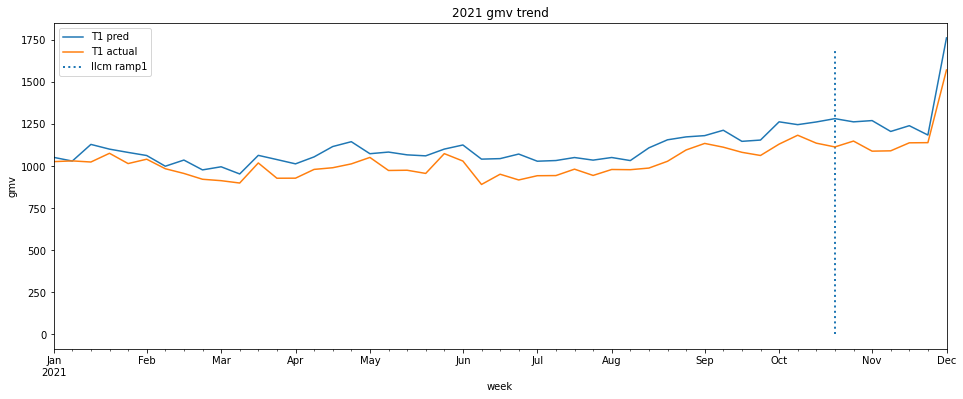

In [33]:
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=1700, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv')
plt.title('2021 gmv trend')
plt.legend()

In [37]:
y_all[y_all.index>'2021-10-22'].diff(axis=1).sum()

T1 pred        0.000000
T1 actual   -749.797507
dtype: float64

## Preperiod 

In [38]:
preperiod_cm = ts_T1.query('dt < "2021-10-22"')\
        .groupby(['week', 'ramp'])['cm'].sum().reset_index()\
        .pivot(index='ramp', columns='week').T

preperiod_cm

ramp                                 C1             C2             T1  \
   week                                                                 
cm 2020-12-28/2021-01-03   64375.564790   57299.060628   51677.047945   
   2021-01-04/2021-01-10  128822.287613  143109.223747  121333.394940   
   2021-01-11/2021-01-17  141146.422225  138986.860629  141029.953821   
   2021-01-18/2021-01-24  135509.187356  143852.327199  143766.642209   
   2021-01-25/2021-01-31  134687.533898  141045.938729  125348.204953   
...                                 ...            ...            ...   
   2021-09-20/2021-09-26   85870.604802  101280.649260   87783.806424   
   2021-09-27/2021-10-03  107609.267741  107215.177973  105203.362982   
   2021-10-04/2021-10-10   97466.304253  107236.965554   84632.699309   
   2021-10-11/2021-10-17   81808.744130   90549.878664   86708.762585   
   2021-10-18/2021-10-24   57485.349913   66018.878948   50624.894795   

ramp                                 T2  
   week                                  
cm 2020-12-28/2021-01-03   46733.390867  
   2021-01-04/2021-01-10  105298.818165  
   2021-01-11/2021-01-17  143322.720810  
   2021-01-18/2021-01-24  114792.039683  
   2021-01-25/2021-01-31  143405.077125  
...                                 ...  
   2021-09-20/2021-09-26  108415.614199  
   2021-09-27/2021-10-03  107434.622693  
   2021-10-04/2021-10-10   96886.445622  
   2021-10-11/2021-10-17  105925.568990  
   2021-10-18/2021-10-24   61813.343989  

[43 rows x 4 columns]

In [39]:
y_train = preperiod_cm['T1'].values
X_train = preperiod_cm.drop(columns='T1').values
y_train.shape, X_train.shape

clf_cm = Lasso(fit_intercept=False).fit(X_train, y_train)
r2_score(y_train, clf_cm.predict(X_train))

0.9020807980979235

### Apply the model

In [40]:
allperiod_cm = ts_2021.groupby(['week', 'ramp'])['cm'].mean().reset_index()\
                    .pivot(index='ramp', columns='week').T
y_actual = allperiod_cm['T1'].values
X_all = allperiod_cm.drop(columns='T1').values
y_actual.shape, X_all.shape

((49,), (49, 3))

In [41]:
y_pred = clf_cm.predict(X_all)
r2_score(y_actual, y_pred)

0.7975026725100711

In [42]:
y_all = pd.DataFrame(index=allperiod.index.get_level_values(1), \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all

,T1 pred,T1 actual
week,,
2020-12-28/2021-01-03,111.532719,97.320241
2021-01-04/2021-01-10,105.599314,100.524768
2021-01-11/2021-01-17,115.566654,116.940260
2021-01-18/2021-01-24,112.974419,118.521552
2021-01-25/2021-01-31,111.704848,102.828716
...,...,...
2021-11-01/2021-11-07,92.339437,80.923742
2021-11-08/2021-11-14,50.588075,48.519814
2021-11-15/2021-11-21,71.272263,66.604907


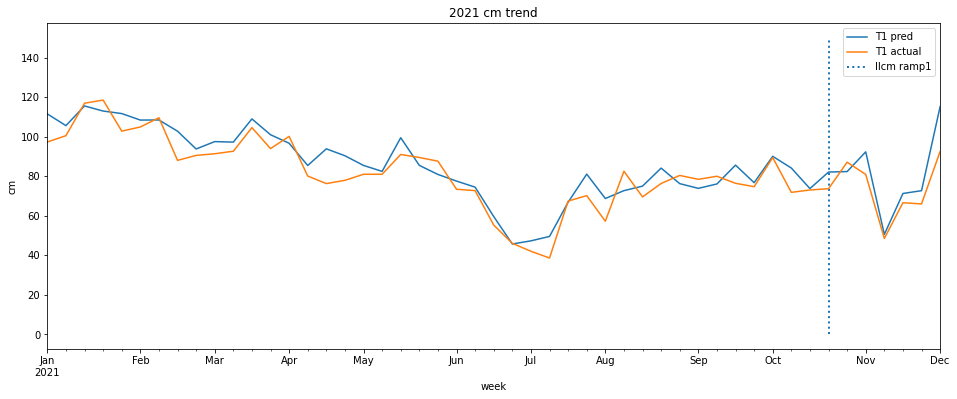

In [45]:
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=150, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

In [46]:
y_all[y_all.index>'2021-10-22'].diff(axis=1).sum()

T1 pred       0.000000
T1 actual   -42.805734
dtype: float64